<a href="https://colab.research.google.com/github/ryanharvey1/teamA-grebes-NMA2020/blob/master/speed_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find running calcium response correlations

This script finds significant linear relationships between calcium response and running speed

In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sys
import pandas as pd          

## download data

TODO: make general for wider dataset

In [2]:
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())        

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## get correlation

In [3]:
def compute_speed_mod(speed,fr):
  speed_score = np.corrcoef(speed,fr)[0,1]
  return speed_score

## get shuffled pvalue

Each cell’s response vector was shuffled by a random interval from ~20 s before or after its true position


In [4]:
def shuffle_speed_mod(speed_score,speed,fr,shuffn=250):
  a = -20;
  b = 20; 
  r = np.random.randint(a,b,shuffn)

  speed_score_shuff = []
  for i in range(len(r)):
    sc = compute_speed_mod(speed,np.roll(fr,r[i]))
    speed_score_shuff.append(sc)
 
  # DOI: 10.2202/1544-6115.1585
  shuff_pvalue = (sum(np.abs(speed_score_shuff) > np.abs(speed_score)) + 1) /(len(speed_score_shuff) + 1);

  return shuff_pvalue

## get slope and intercept using linear regression

In [5]:
def get_slope_intercept(speed,fr):

  x = speed[np.newaxis].T
  y = fr[np.newaxis].T

  model = LinearRegression()
  model.fit(x,y)

  m = model.coef_
  b = model.intercept_
  return m,b

## get speed maps 

speed maps are the mean neural response at each speed bin 

In [6]:
def get_speed_map(speed,fr):
  speed_vec = np.arange(min(run),np.percentile(run,95),2)

  fr_speed_maps = []
  # get mean firing rate in each speed bin
  for j in range(len(speed_vec)-1):
    start = speed_vec[j]
    stop = speed_vec[j+1]

    idx = [speed > start] and [speed < stop]
    fr_speed_maps.append(np.mean(fr[tuple(idx)]))

    # sem.append(np.std(fr(idx)) / np.sqrt(len(fr(idx))))
  return fr_speed_maps

## run though every cell

In [7]:
cells,time = dat['sresp'].shape
run = np.squeeze(dat['run'])
X = dat['sresp']

speed_score = []
shuff_pvalue = []
m = []
b = []
speed_map = []

for i in range(cells):
  # get speed response correlation
  speed_score.append(compute_speed_mod(run,X[i,:]))
  
  # shuffle correlation
  shuff_pvalue.append(shuffle_speed_mod(speed_score[-1],run,X[i,:]))
  
  # linear regression
  m_,b_ = get_slope_intercept(run,X[i,:])
  m.append(m_)
  b.append(b_)

  # speed map
  speed_map.append((get_speed_map(run,X[i,:])))

  # update counter
  sys.stdout.write('\rcurrent cell: %d' %(cells - i))
  sys.stdout.flush()

d={'speed_score': speed_score, 'shuff_pvalue': shuff_pvalue,
          'slope': m, 'intercept': b}
df = pd.DataFrame(d)


current cell: 1

In [8]:
df

,speed_score,shuff_pvalue,slope,intercept
0,0.054917,0.083665,[[0.04655153712639664]],[6.701278006979309]
1,-0.011551,0.374502,[[-0.008001666373229879]],[5.433671749085655]
2,-0.011675,0.247012,[[-0.0073181789721904495]],[4.6965754671733455]
3,0.046078,0.685259,[[0.06816048084295674]],[8.474296393925272]
4,0.048107,0.031873,[[0.08151148078289507]],[13.27337580967431]
...,...,...,...,...
11978,-0.030765,0.139442,[[-0.31601890375345476]],[86.03674125511317]
11979,-0.004624,0.721116,[[-0.020151207141361857]],[35.48008323940126]
11980,-0.002614,0.916335,[[-0.010835917051686884]],[32.71565770394717]
11981,-0.025612,0.159363,[[-0.16513455051549225]],[53.14822019287467]


## If data was already ran, load it here

In [9]:
np.save('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy',speed_map)
speed_map = np.load('/content/drive/My Drive/nma_data/6163622_v6/speed_map.npy')

df.to_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_cor.pkl")
df = pd.read_pickle("/content/drive/My Drive/nma_data/6163622_v6/speed_cor.pkl")
df

,speed_score,shuff_pvalue,slope,intercept
0,0.054917,0.083665,[[0.04655153712639664]],[6.701278006979309]
1,-0.011551,0.374502,[[-0.008001666373229879]],[5.433671749085655]
2,-0.011675,0.247012,[[-0.0073181789721904495]],[4.6965754671733455]
3,0.046078,0.685259,[[0.06816048084295674]],[8.474296393925272]
4,0.048107,0.031873,[[0.08151148078289507]],[13.27337580967431]
...,...,...,...,...
11978,-0.030765,0.139442,[[-0.31601890375345476]],[86.03674125511317]
11979,-0.004624,0.721116,[[-0.020151207141361857]],[35.48008323940126]
11980,-0.002614,0.916335,[[-0.010835917051686884]],[32.71565770394717]
11981,-0.025612,0.159363,[[-0.16513455051549225]],[53.14822019287467]


## Figures

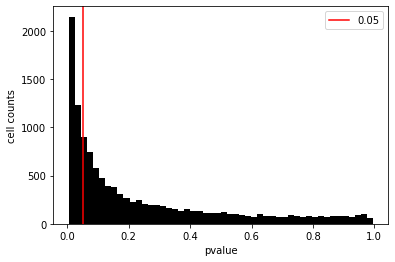

3748  of  11983  cells are modulated by running speed


In [11]:
plt.figure()
plt.hist(shuff_pvalue,50,color='k')
plt.axvline(0.05,color = 'r',label='0.05')
plt.xlabel('pvalue')
plt.ylabel('cell counts')
plt.legend()
plt.show()

print(sum(df.shuff_pvalue < 0.05),' of ',cells,' cells are modulated by running speed')